In [118]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('../..'))))

import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from src.models.feature.GooLeNet import GoogLeNet
from src.models.feature.ResNet import ResNet18
from src.models.module.pooling import GVAP, GAP
from torch.nn import functional as F

In [121]:
if torch.cuda.is_available():
    device = 'cuda'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'
    torch.set_default_tensor_type('torch.FloatTensor')

#class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_name = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

model = ResNet18(classes=len(class_name),alpha=0,cal='plus').to(device)

model.load_state_dict(torch.load('./pretrain/resnet18_stl10_gap_model.pth'))

model = model.eval()

In [122]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Block1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (relu2): ReLU()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1):

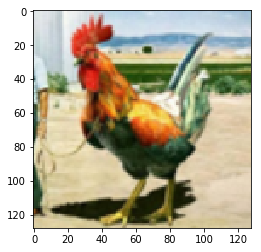

In [176]:
img_path = './test_img/stl10/test.png'

img = Image.open(img_path)

plt.imshow(img)

In [177]:
import torchvision.transforms as transforms
from torch.autograd import Variable

cvt_tensor = transforms.Compose([transforms.Resize((128,128)),
                                 transforms.ToTensor()])

tensor_img = cvt_tensor(img).to(device)

tensor_img = tensor_img.view(1, 3, 128, 128)

In [181]:
n_samples = 25
stdev_spread = 0.15

stdev = stdev_spread / (tensor_img.max() - tensor_img.min())
std_tensor = torch.ones_like(tensor_img) * stdev

x_with_noise = torch.normal(mean=tensor_img, std=std_tensor)

In [182]:
gradients = []

def save_gradient(grad):
    gradients.append(grad)
    
x_with_noise = Variable(x_with_noise, requires_grad=True)

In [183]:
output = model(x_with_noise)
classes = F.softmax(output, dim=1)

In [184]:
print(classes.data[0].sort(0, True))

torch.return_types.sort(
values=tensor([9.9993e-01, 3.8232e-05, 3.3371e-05, 3.9473e-07, 3.7820e-07, 3.4120e-07,
        1.5037e-08, 3.8897e-09, 1.5412e-09, 4.7543e-10]),
indices=tensor([1, 9, 8, 4, 0, 5, 6, 7, 2, 3]))


In [185]:
one_hot, idx = classes.max(dim=1)

model.zero_grad()
one_hot.backward()

In [186]:
grad = x_with_noise.grad.data.cpu().numpy()

In [187]:
avg_grdients = grad[0, ...] / n_samples

In [188]:
avg_grdients.shape

(3, 128, 128)

In [189]:
import cv2

img_2d = np.sum(avg_grdients, axis=0)
span = abs(np.percentile(img_2d, 99))
vmin = -span
vmax = span
img_2d = np.clip((img_2d - vmin) / (vmax - vmin), -1, 1)

print(img_2d)

cv2.imwrite('test.png', img_2d * 255)

[[0.49095246 0.4929272  0.48327002 ... 0.50427014 0.4759497  0.4891935 ]
 [0.3979528  0.32238188 0.3821467  ... 0.54028785 0.50298035 0.47930712]
 [0.37082732 0.4091021  0.43531832 ... 0.5054134  0.47165614 0.45502406]
 ...
 [0.506822   0.511749   0.50936645 ... 0.5297917  0.50988066 0.5142641 ]
 [0.5095797  0.50603527 0.5043944  ... 0.48613283 0.50252783 0.49708045]
 [0.5061962  0.50078875 0.50196844 ... 0.48627436 0.50045365 0.50120693]]


True

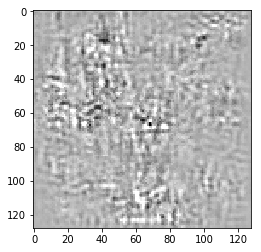

In [190]:
plt.imshow(img_2d,cmap='gray')